In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
import pickle
import numpy as np
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs

# Utils

In [4]:
def plot_gain_dist_by_episode(names, labels=None, title=None, wind_dirs=[45, 90, 135, 180, 225, 270, 315]):
  if not isinstance(names, list):
    names = [names]

  n_envs = len(wind_dirs)
  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  for env_id, wind_dir in enumerate(wind_dirs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Wind dir: {wind_dir}°')
    plot_metric(
      [f'{name}-{env_id}/0' for name in names],
      metric='obs/cum_obs/gain_dist/0',
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True,
      plot_type='mean')

  for i, name in enumerate(names):
    if labels is not None:
      label = labels[i]
    else:
      label = name
    axs[1, 3].plot([], [], label=label)

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=len(names))

In [127]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None, eval=True):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)
  if len(files) == 0:
    files = glob(f'../runs/{name}')

  print(f'Found {len(files)} files')

  folder = 'eval' if eval else 'train'

  by_wind = defaultdict(list)
  by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/{folder}-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/vmc/0'].iloc[-1]*.1
      cum_reward = df[f'reward'].sum()
      by_wind[wind_dir].append((score, cum_reward))
      by_step[step].append((score, cum_reward))

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['policy_kwargs', 'name', 'env_name', 'seed', 'reward_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score', 'Mean cum. reward']
  for step, data in by_step.items():
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores), np.mean(cum_reward)])
  print(pt)
  print()

  steps = list(sorted(steps))

  fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
  for wind_dir in wind_dirs:
    data = by_wind[wind_dir]
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    axs[0].plot(steps, scores, label=f'{wind_dir}°')
    axs[1].plot(steps, cum_reward, label=f'{wind_dir}°')
  axs[0].set_xlabel('Training step')
  axs[1].set_xlabel('Training step')
  axs[0].set_ylabel('Cum. dist.')
  axs[0].set_ylabel('Cum. reward')
  fig.suptitle(name)
  # right legend
  fig.legend(bbox_to_anchor=(1.05, .5), loc='center left')

In [6]:
# def extract_step(filename):
#   res = re.search(r'(\d+)$', filename)
#   return int(res.group(1))

# files = glob('../runs/08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1*')
# files = sorted(files, key=extract_step)

# plot_gain_dist_by_episode(
#   names=[f'{f}/eval-*' for f in files],
#   labels=[f'{round(extract_step(f)/1e3)}K'  for f in files]
# )

# Reflexions

## VMC > gain_dist (maybe)
VMC seems better than gain_dist because it is more stable

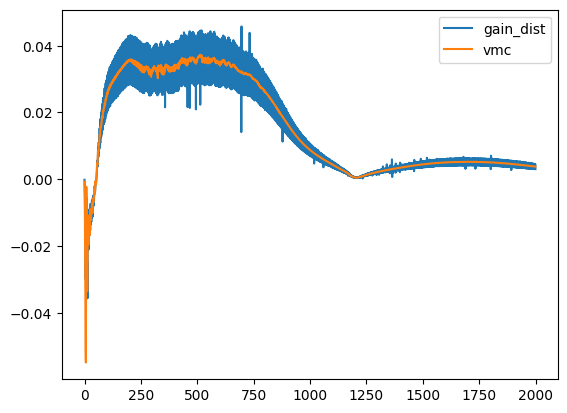

In [30]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/gain_dist/0'].plot(label='gain_dist')
(df['obs/vmc/0']*.1).plot(label='vmc')
plt.legend()

## Remove noisy sensors

- **TAE -> heading error**: TAE is really noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).

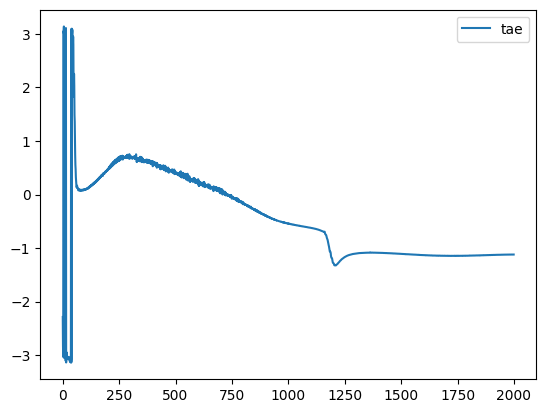

In [40]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/tae/0'].plot(label='tae')
plt.legend()

## $\lvert \dot\theta_{rudder} \rvert \leq 6$

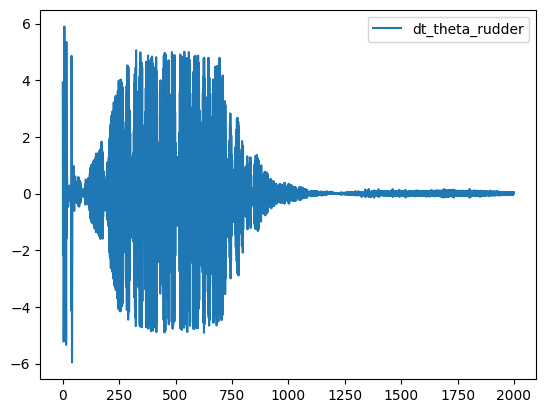

In [45]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='dt_theta_rudder')
plt.legend()

# $\lvert VMC \rvert \lessapprox .4$

<Axes: >

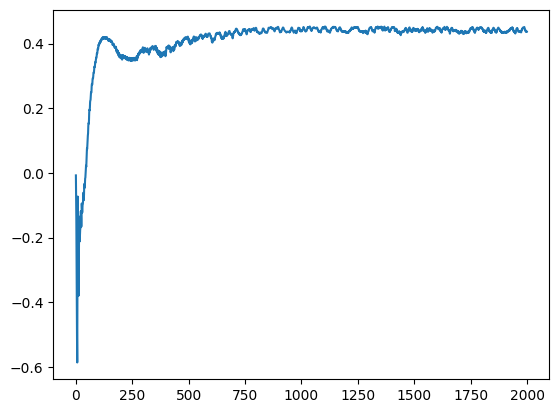

In [49]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-1/0')
df = dfs.popitem()[1]
df['obs/vmc/0'].plot()

In [23]:
dfs = get_dfs('08-30-B1-69972/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/cum_obs/g']

0      -0.007584
1      -0.060063
2      -0.131415
3      -0.267325
4      -0.369382
          ...   
1995   -0.055577
1996   -0.055567
1997   -0.055558
1998   -0.055539
1999   -0.055525
Name: reward, Length: 2000, dtype: float64

# Eval 1M steps with best hyperparams
- **Result:** degredation of performance
- **Hypothesis:** the observation was too big and possibly noisy

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v3          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 8                 |
|       gamma       |               0.999               |
|   l

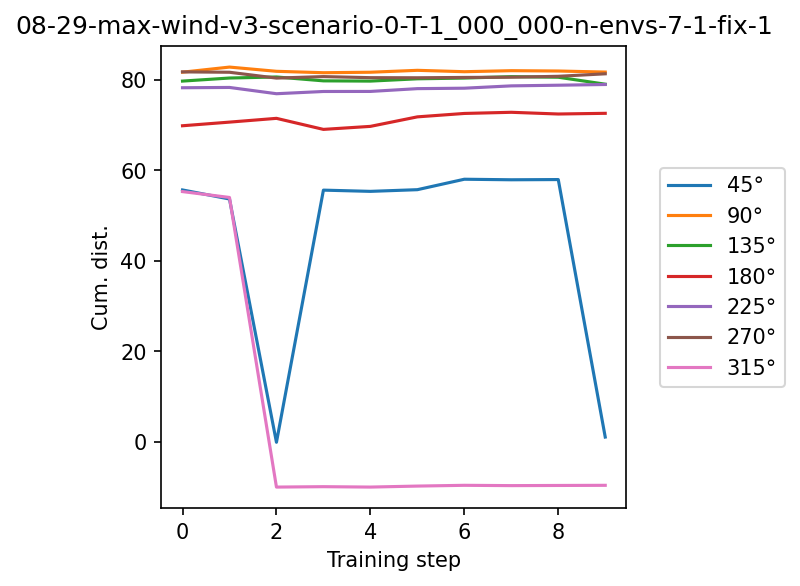

In [196]:
plot_training_evolution('08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1', model_folder='08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1')

# Testing with smaller observation space (basic_2d_obs_v4) & trying with different episode duration

- **Result:** Full episode duration is better. At the end the training "crashed" because is learn to take good direction to maximize the velocity but did not learn yet to be safe about the corridor. Moreover, I find out that the observation/reward was noisy.
- **Hypothesis:** Need larger training time and stable observation/reward

## Episode duration = **200s**

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A"

screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

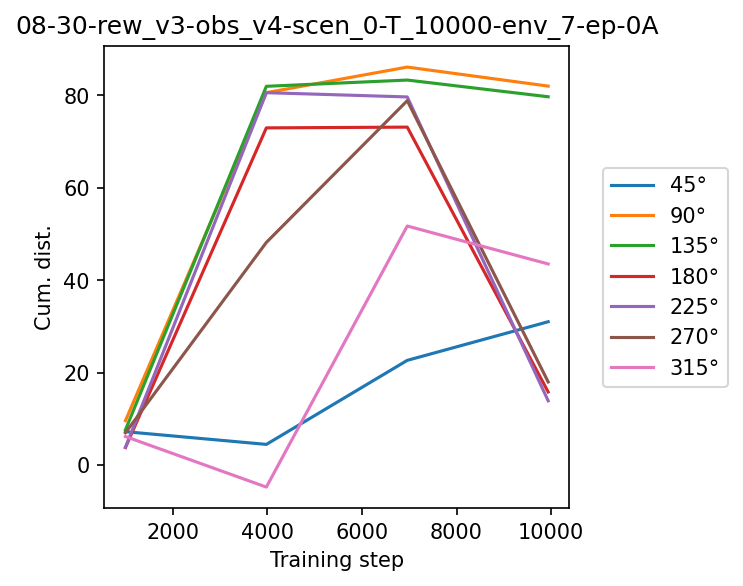

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

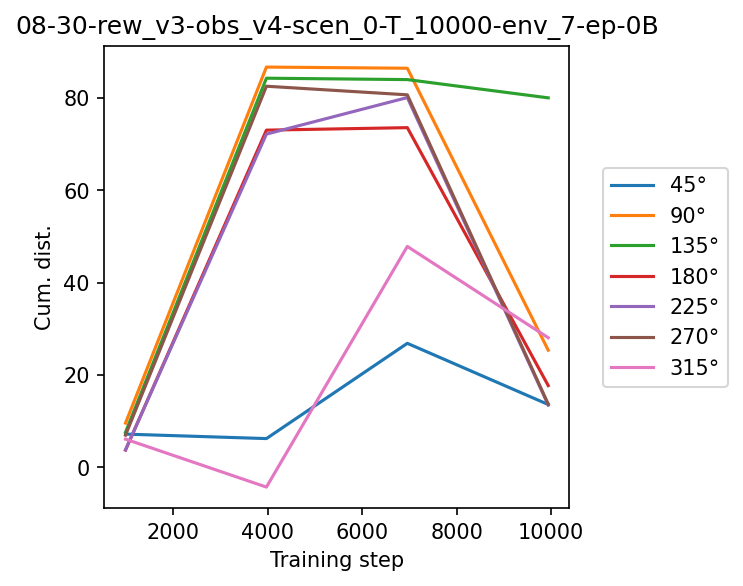

In [53]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B')

## Episode duration = **100s**

```bash
screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A"

screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

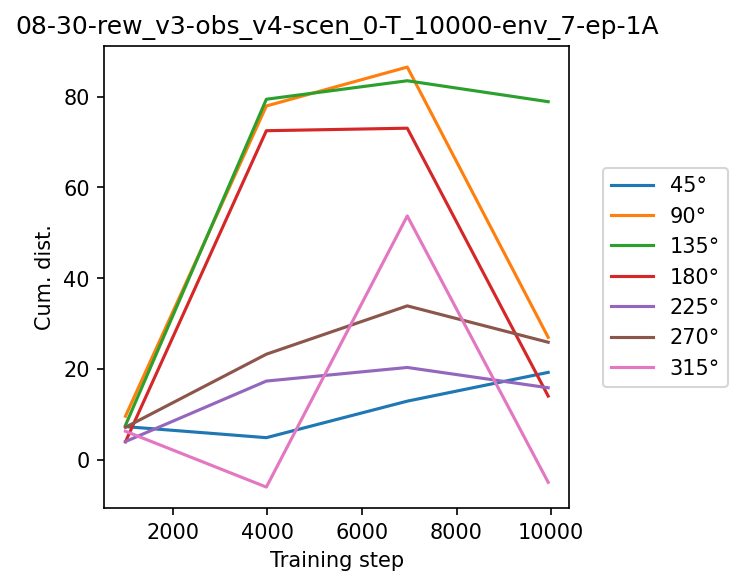

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

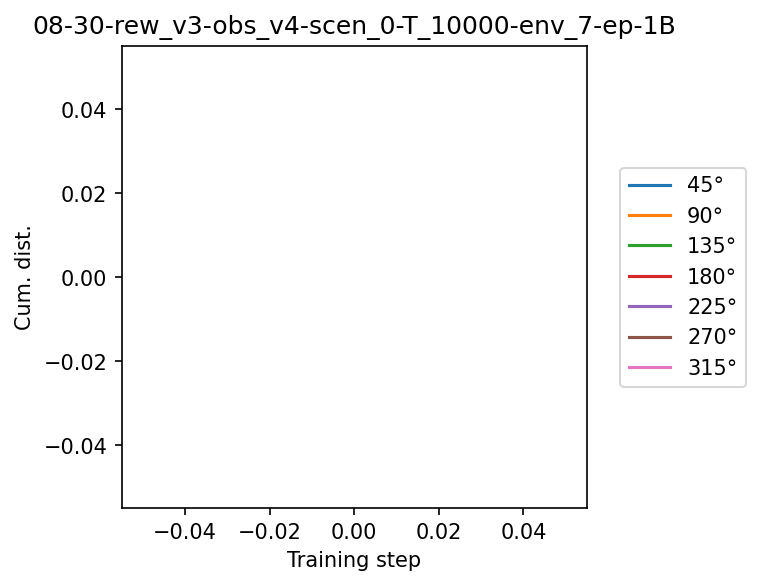

In [56]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B')

## Episode duration = **50**

```bash
screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A"

screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                 50                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

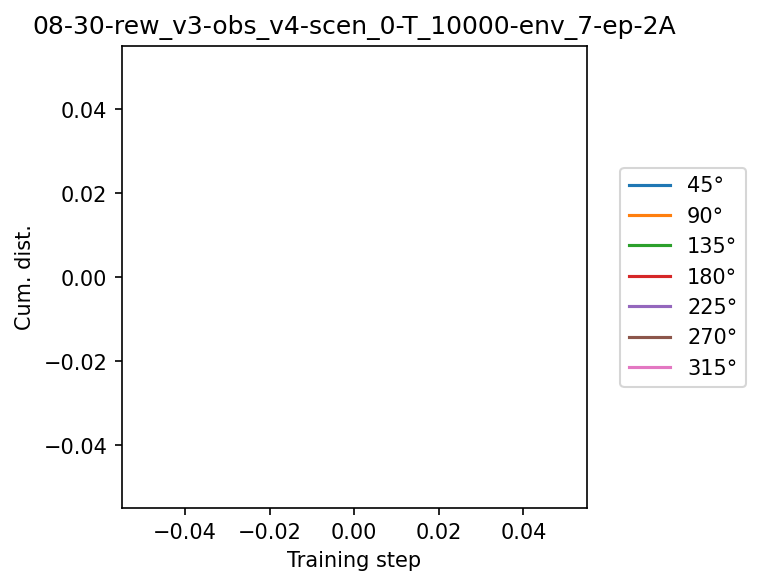

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                 50                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

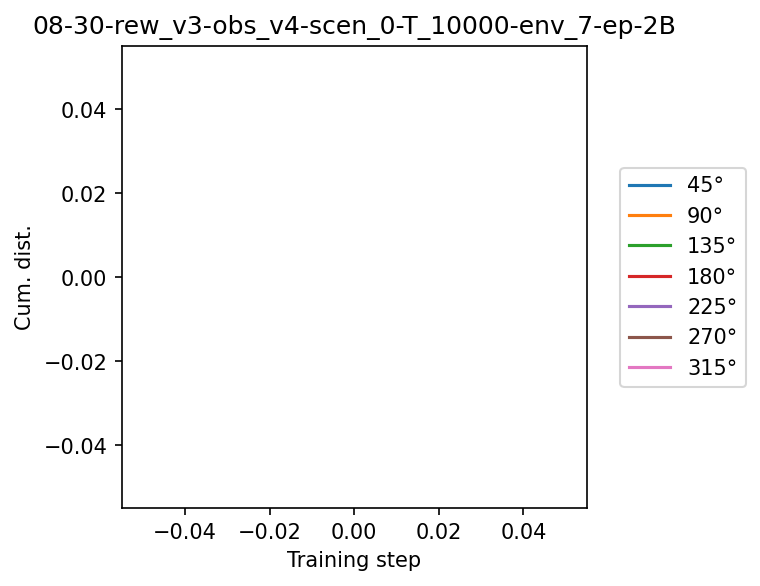

In [210]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B')

# Testing with stable observations and VMC reward
- **Changes:**
  - **gain dist -> VMC**: VMC reward is more stable than gain dist
  - **TAE-> heading error**: TAE is noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).
- **Results:** VMC + 0.01 * heading error seems better (more stable)

## VMC + .001*penalty

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v1            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

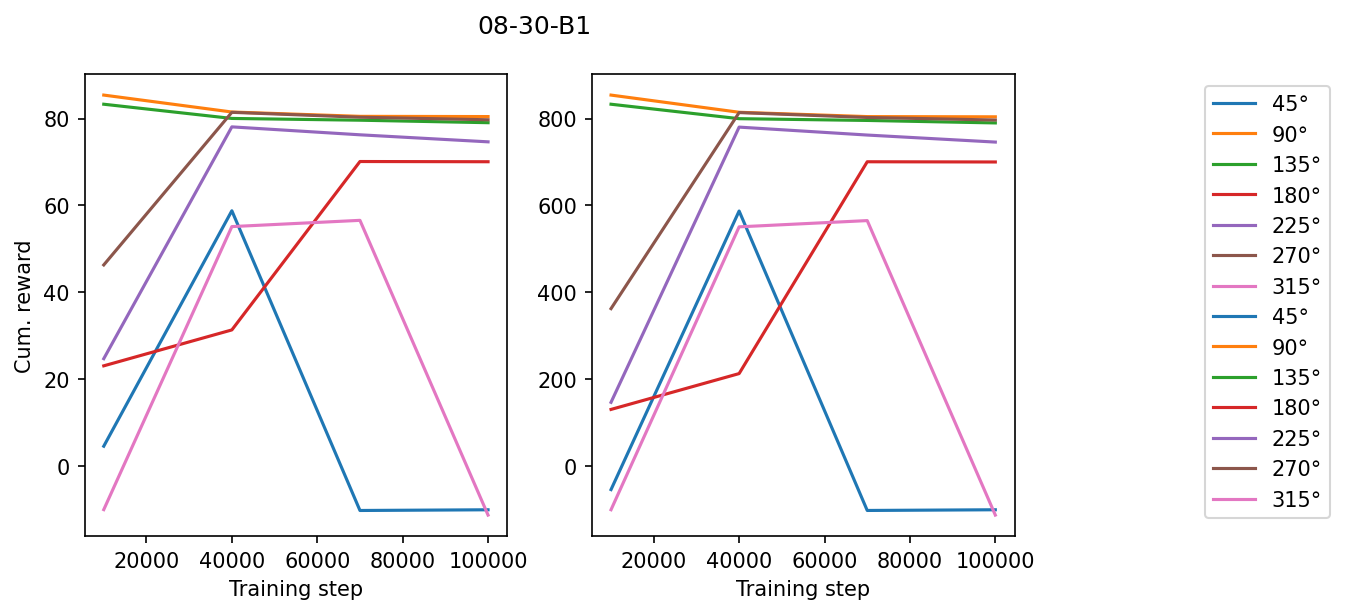

In [36]:
plot_training_evolution('08-30-B1')

## VMC + .005*penalty

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v2            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

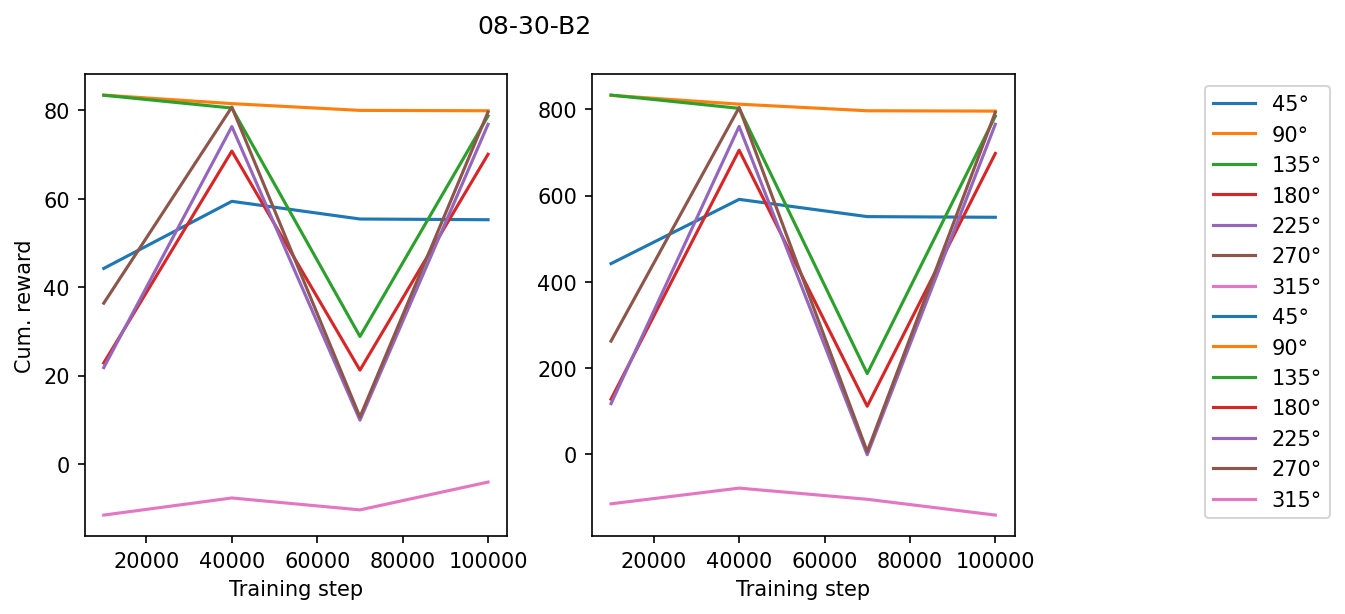

In [41]:
plot_training_evolution('08-30-B2')

## VMC + .01*penalty

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

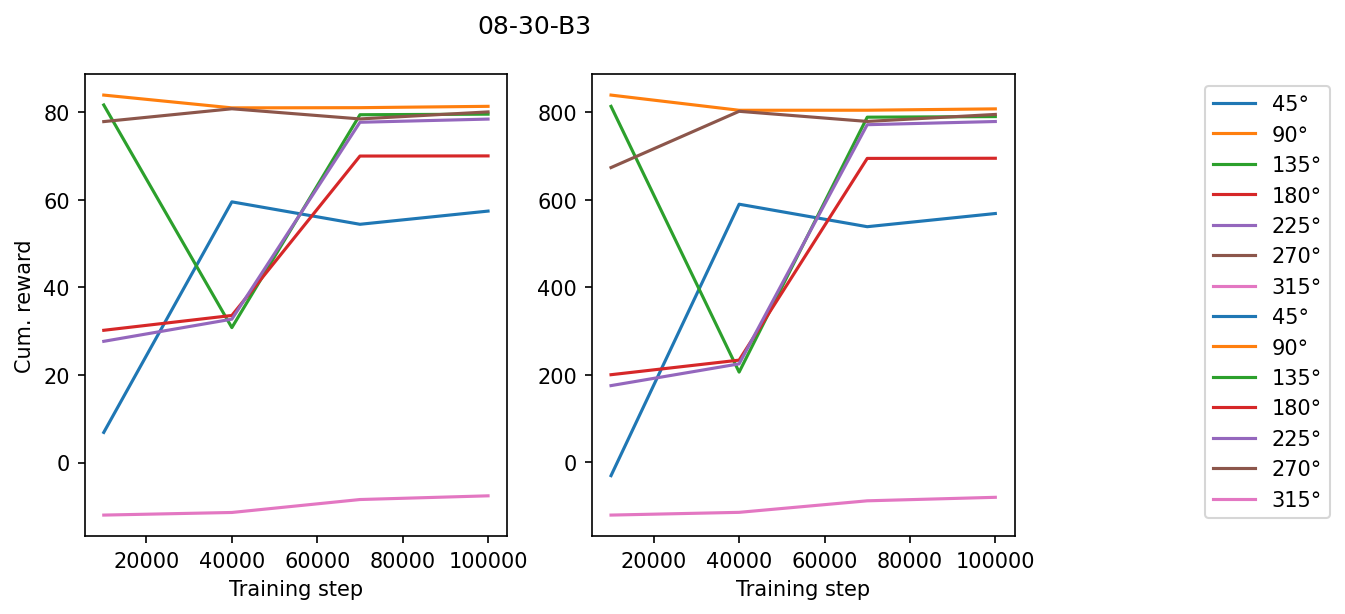

In [38]:
plot_training_evolution('08-30-B3')

## VMC + .05*penalty

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v4            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

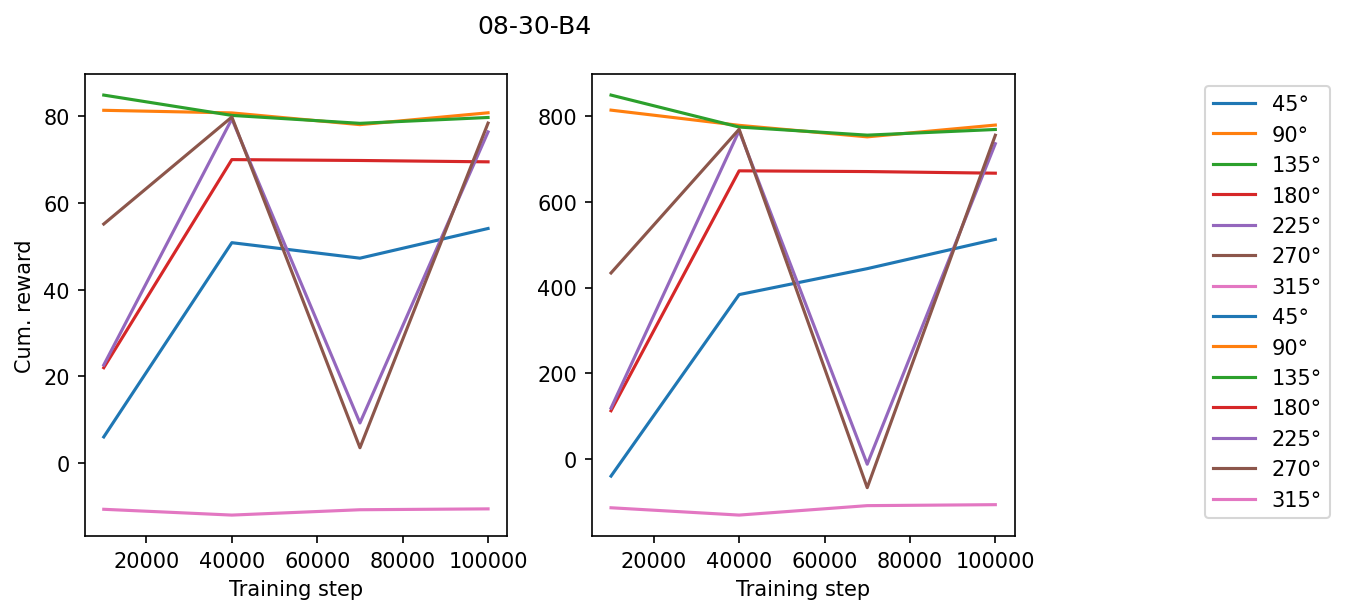

In [42]:
plot_training_evolution('08-30-B4')

## VMC + .1*penalty

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v5            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

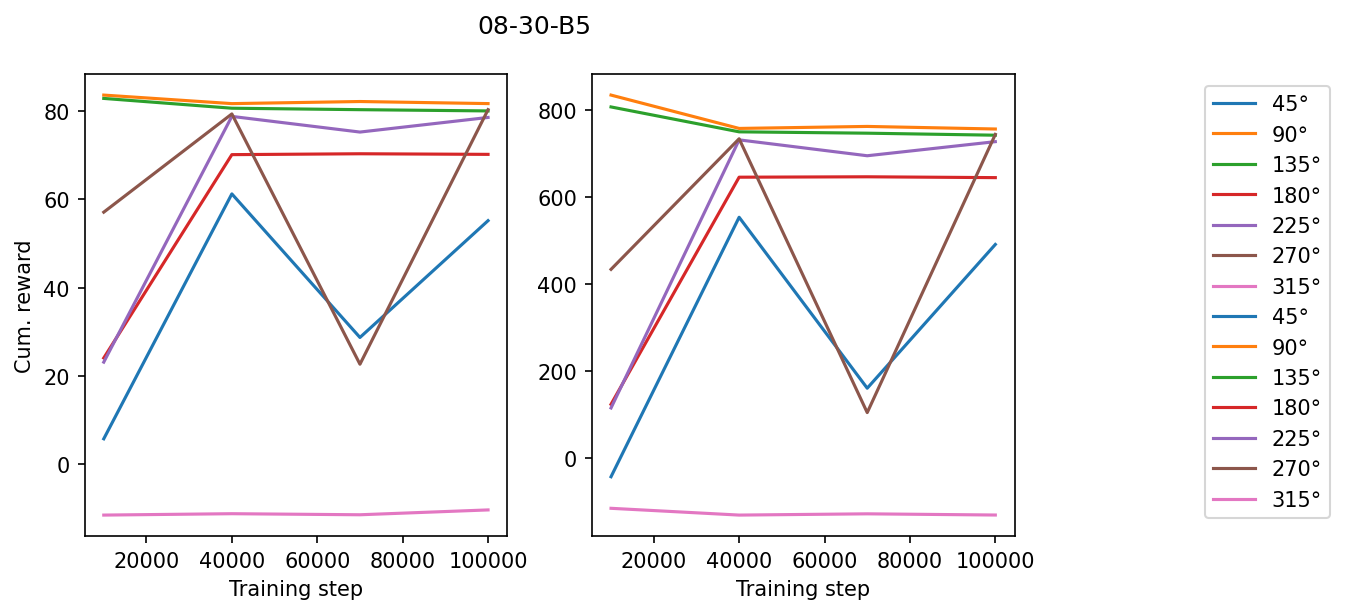

In [40]:
plot_training_evolution('08-30-B5')

## VMC + .5*penalty

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_vmc_v1 --obs=basic_2d_obs_v4 --total=100000 --n-envs=7 --name="08-30-B6"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v6            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

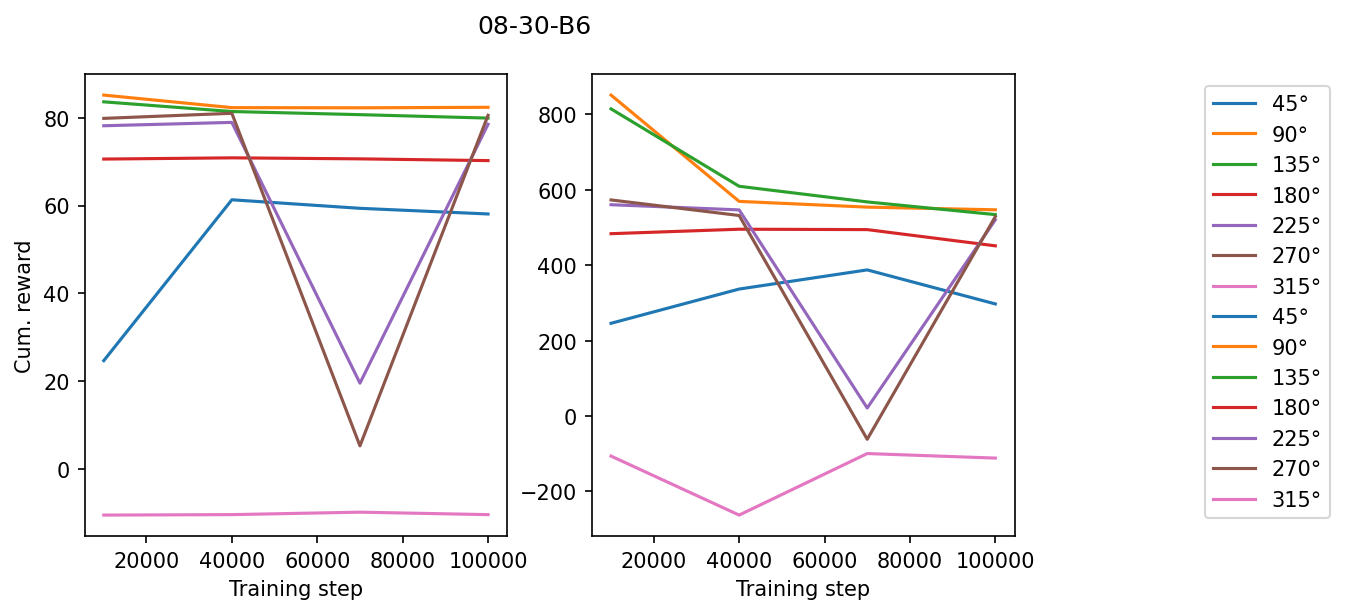

In [43]:
plot_training_evolution('08-30-B6')

# Trying with greater learning rate but **3e-5** seems the best

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

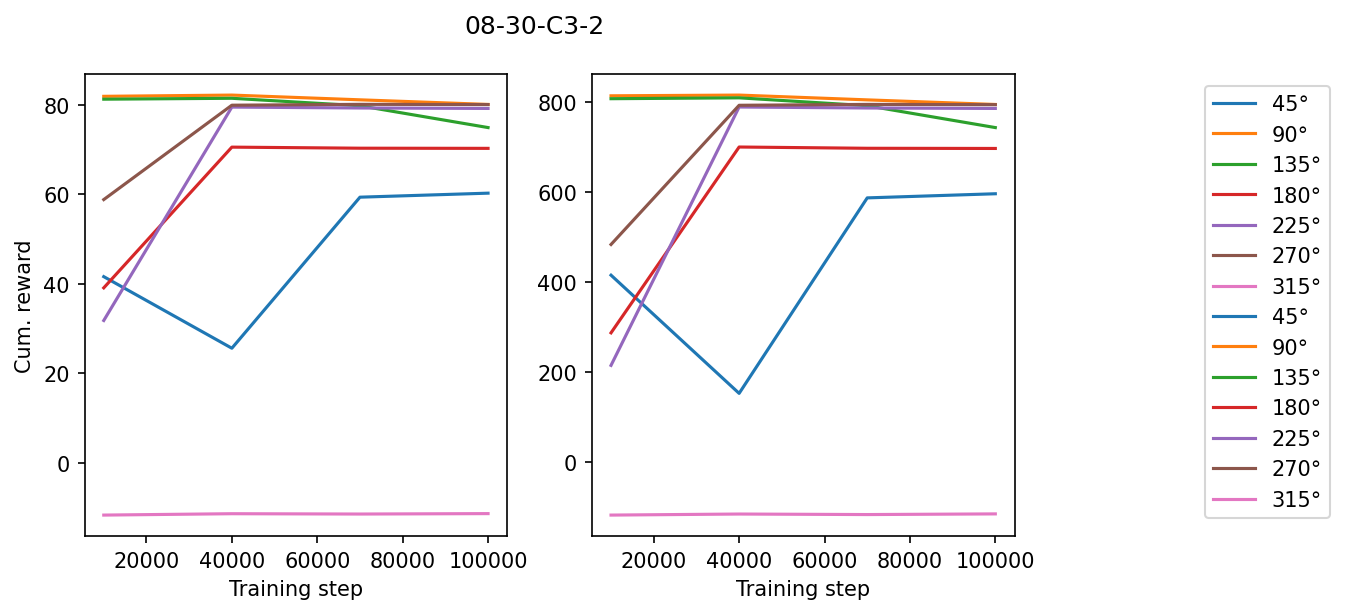

In [88]:
plot_training_evolution('08-30-C3-2')

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

ValueError: x and y must have same first dimension, but have shapes (6,) and (10,)

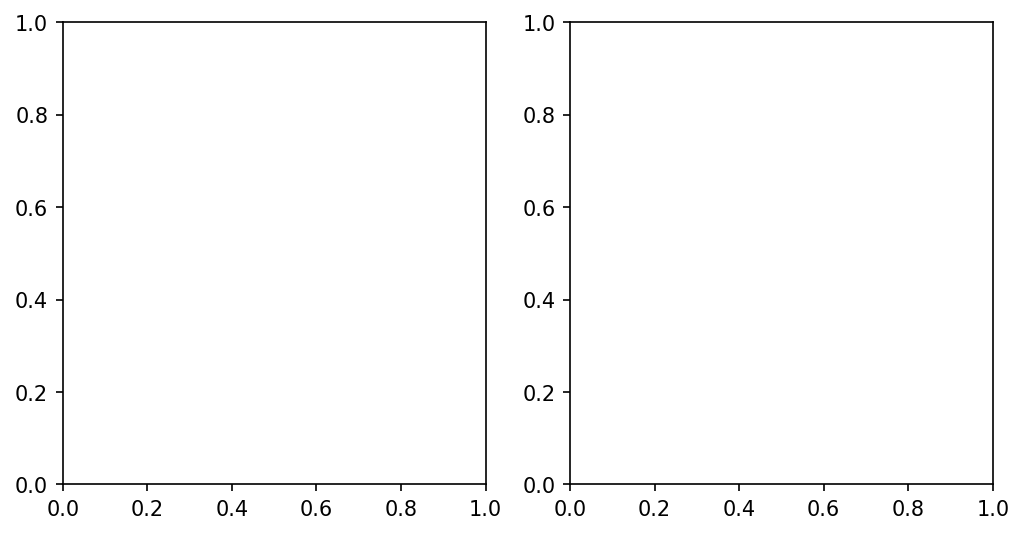

In [78]:
plot_training_evolution('08-30-C3')

In [77]:
np.pi / 2

1.5707963267948966

<Axes: >

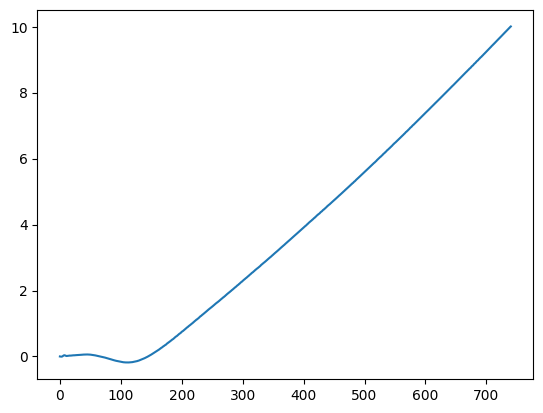

In [87]:
dfs = get_dfs('08-30-C3-69972/eval-08-30-C3-69972-1/0')
df = dfs.popitem()[1]
# np.corrcoef(df['obs/theta_rudder/0'].values, df['act/mlp'].values)
# df['act/mlp'].corr(df['obs/theta_rudder/0'].values[1:])
# df['obs/theta_rudder/0'][:200].plot()
df['obs/xte/0'].plot()
# df['act/mlp'][:200].plot()

# np.corrcoef(df['obs/dt_theta_rudder/0'].values, df['act/mlp'].values)

# zefze

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

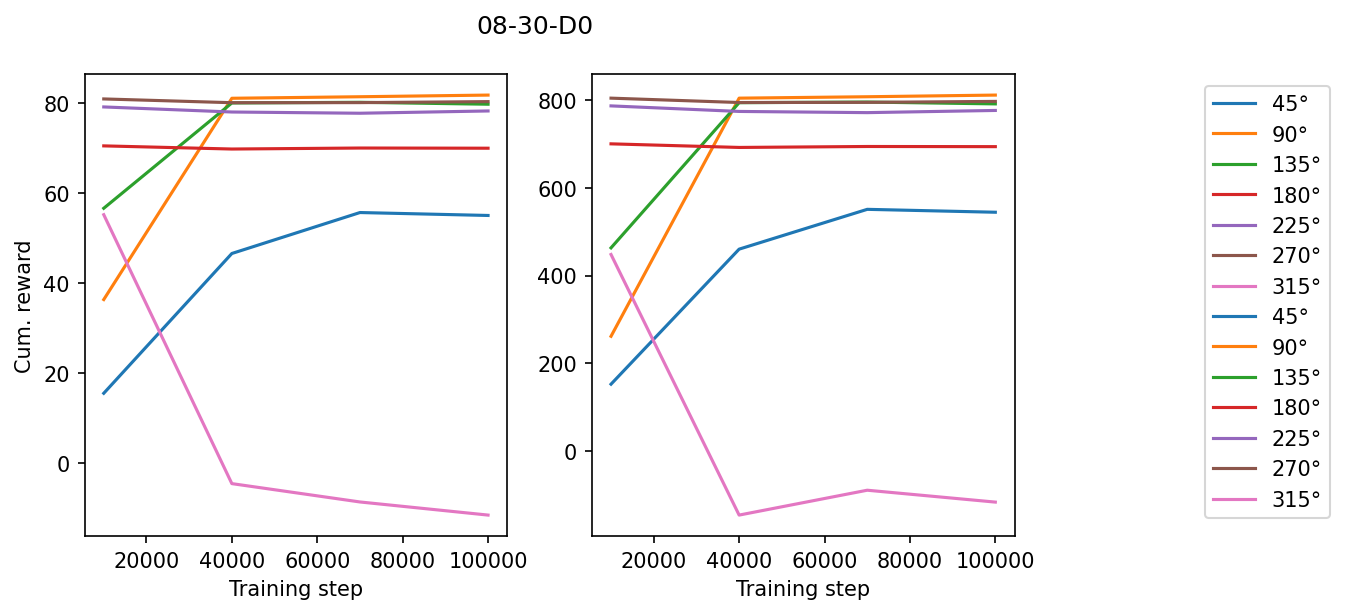

In [89]:
plot_training_evolution('08-30-D0')

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

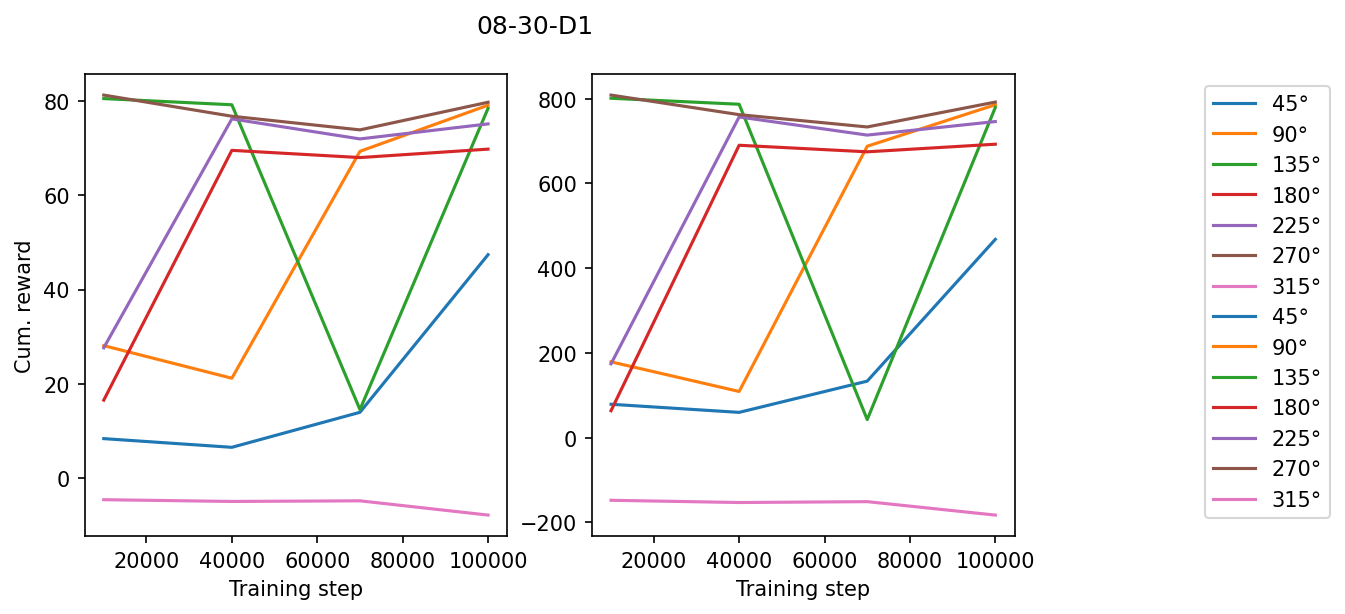

In [94]:
plot_training_evolution('08-30-D1')

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

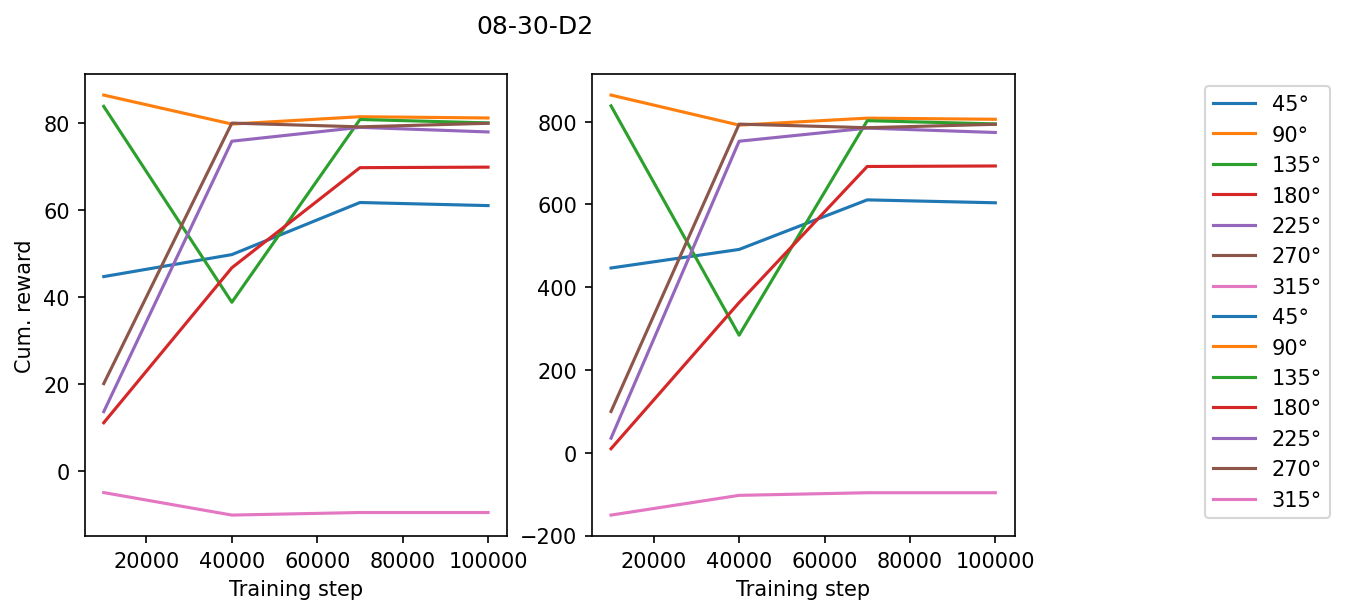

In [97]:
plot_training_evolution('08-30-D2')

# Debug: why does E0 is not learning?

Found 8 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v8            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

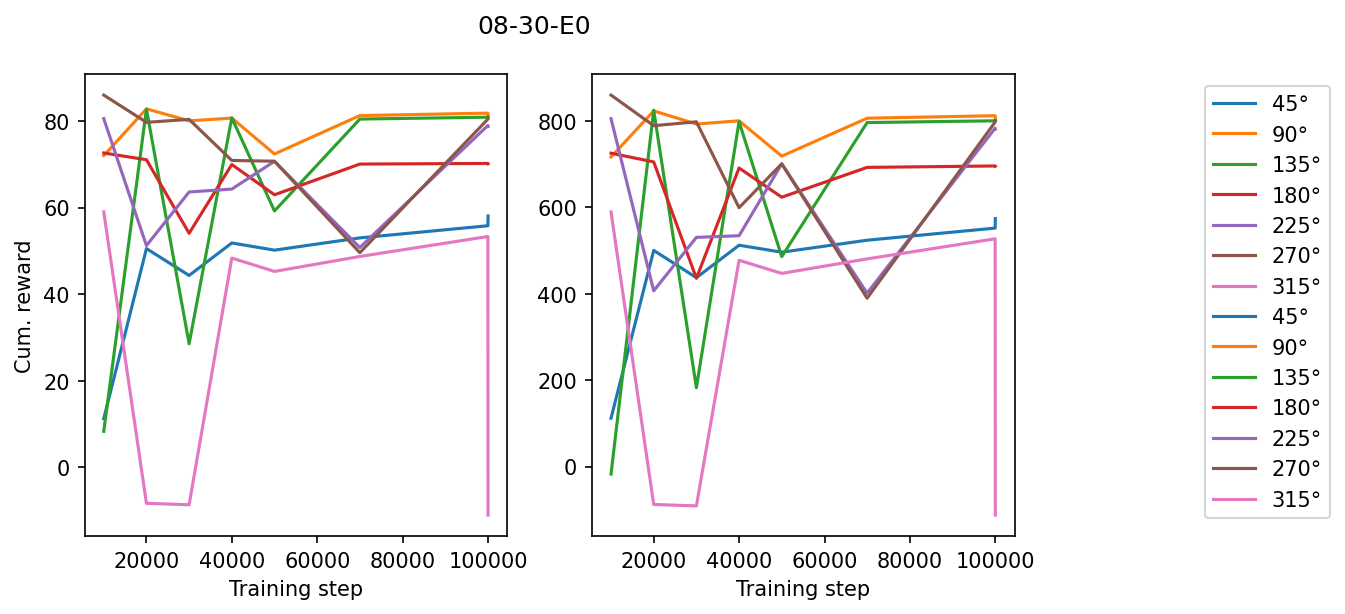

In [148]:
plot_training_evolution('08-30-E0')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v8            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

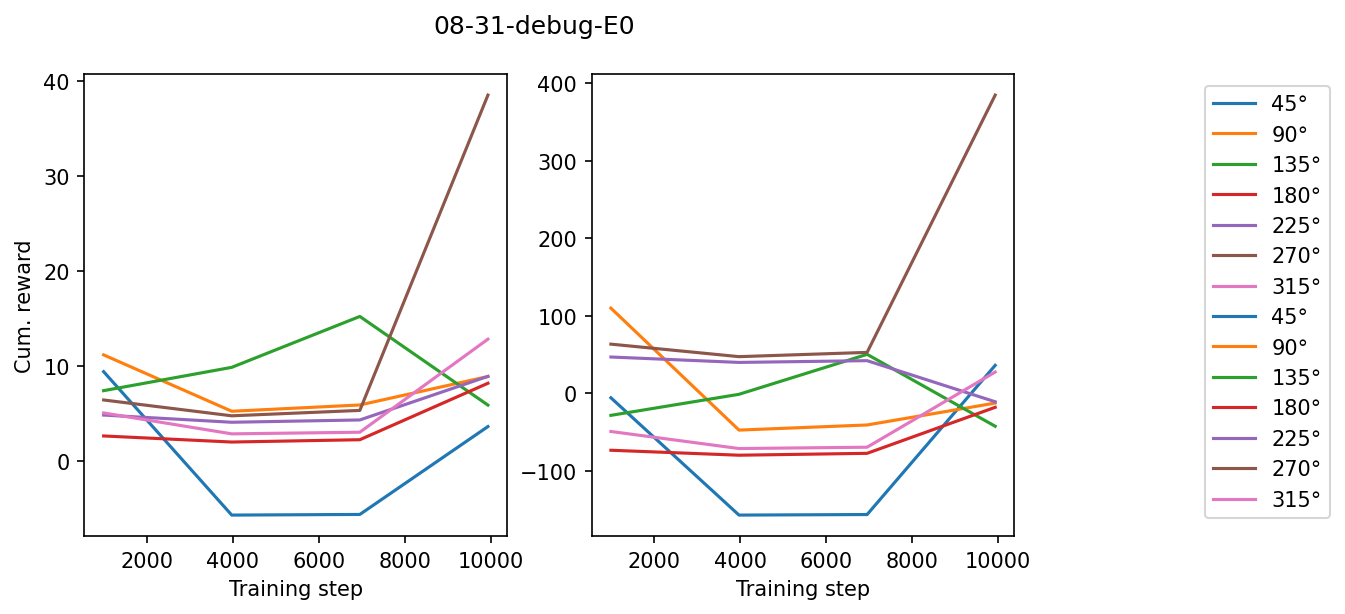

In [163]:
plot_training_evolution('08-31-debug-E0')

Failed to load 1 files for 08-31-debug-2-E0-19950/**/*


<Axes: xlabel='Timesteps', ylabel='act/mlp'>

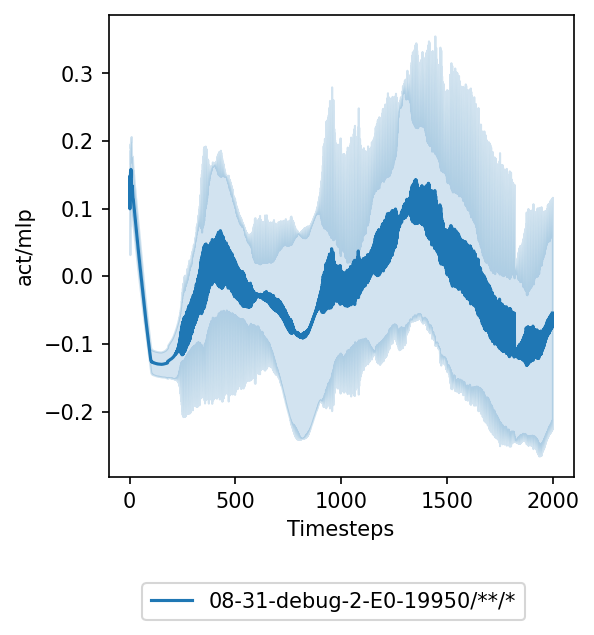

In [176]:
from utils import plot_metric

plot_metric(
  [
    # '08-31-debug-E0-994/**/*',
    # '08-31-debug-E0-3976/**/*',
    # '08-31-debug-E0-6958/**/*',
    # '08-30-E0-19992/**/*',
    # '08-31-debug-2-E0-19950/**/*',

    # '08-31-debug-2-E0-1995/**/*',
    # '08-31-debug-2-E0-3990/**/*',
    # '08-31-debug-2-E0-5985/**/*',
    # '08-31-debug-2-E0-7980/**/*',
    # '08-31-debug-2-E0-9975/**/*',
    # '08-31-debug-2-E0-11970/**/*',
    # '08-31-debug-2-E0-13965/**/*',
    # '08-31-debug-2-E0-15960/**/*',
    # '08-31-debug-2-E0-17955/**/*',
    '08-31-debug-2-E0-19950/**/*',
  ],
  metric='act/mlp')

Failed to load 1 files for 08-30-E0-9996/**/*


Failed to load 1 files for 08-30-E0-19992/**/*


<Axes: xlabel='Timesteps', ylabel='act/mlp'>

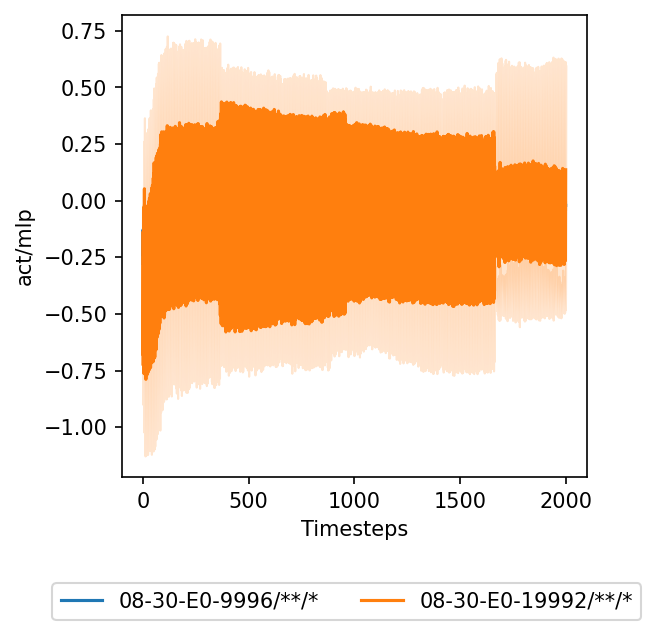

In [160]:
plot_metric(
  [
    '08-30-E0-9996/**/*',
    '08-30-E0-19992/**/*',
  ],
  metric='act/mlp')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


Failed to load 1 files for 08-31-debug-E0-6958/**/*


<Axes: xlabel='Timesteps', ylabel='obs/theta_rudder/0'>

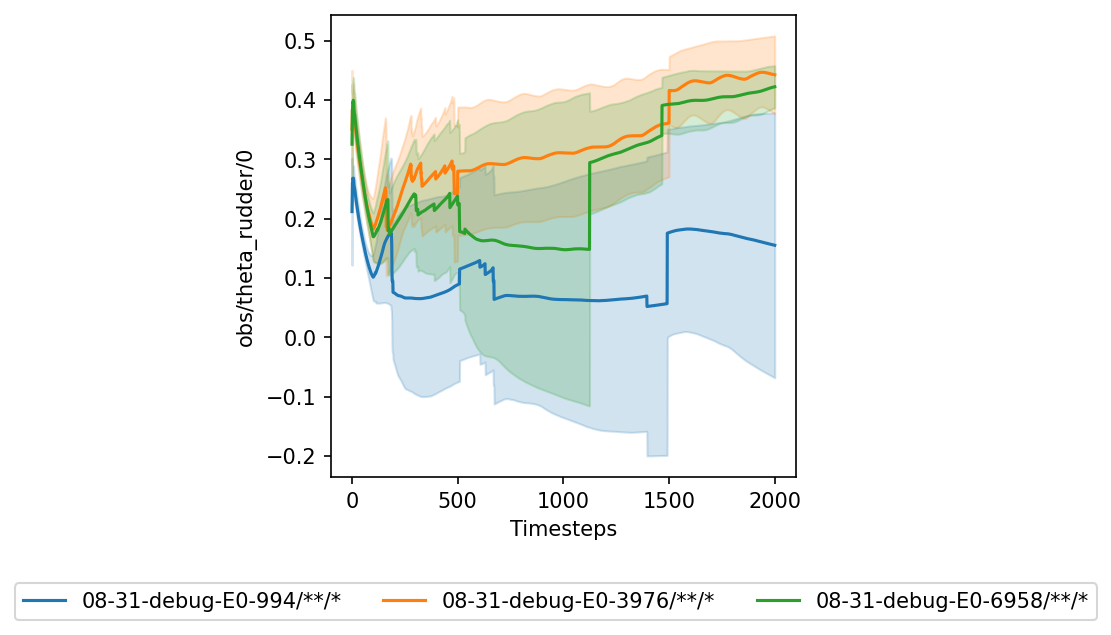

In [155]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
    '08-31-debug-E0-6958/**/*',
  ],
  metric='obs/theta_rudder/0')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


Failed to load 1 files for 08-31-debug-E0-6958/**/*


<Axes: xlabel='Timesteps', ylabel='obs/dt_theta_rudder/0'>

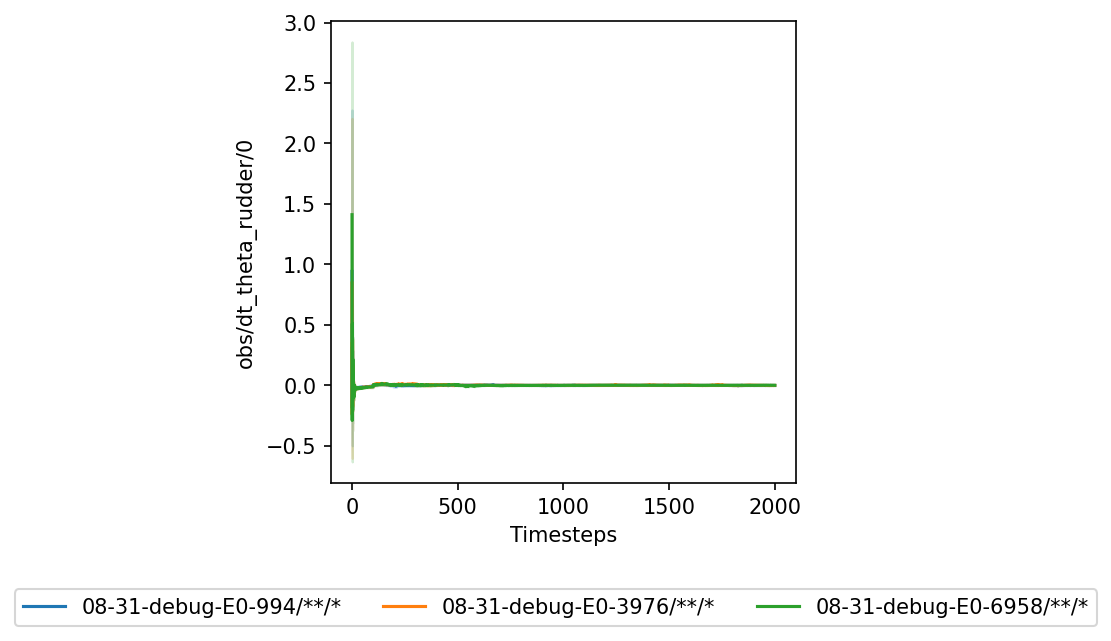

In [156]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
    '08-31-debug-E0-6958/**/*',
  ],
  metric='obs/dt_theta_rudder/0')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


Failed to load 1 files for 08-31-debug-E0-6958/**/*


<Axes: xlabel='Timesteps', ylabel='obs/xte/0'>

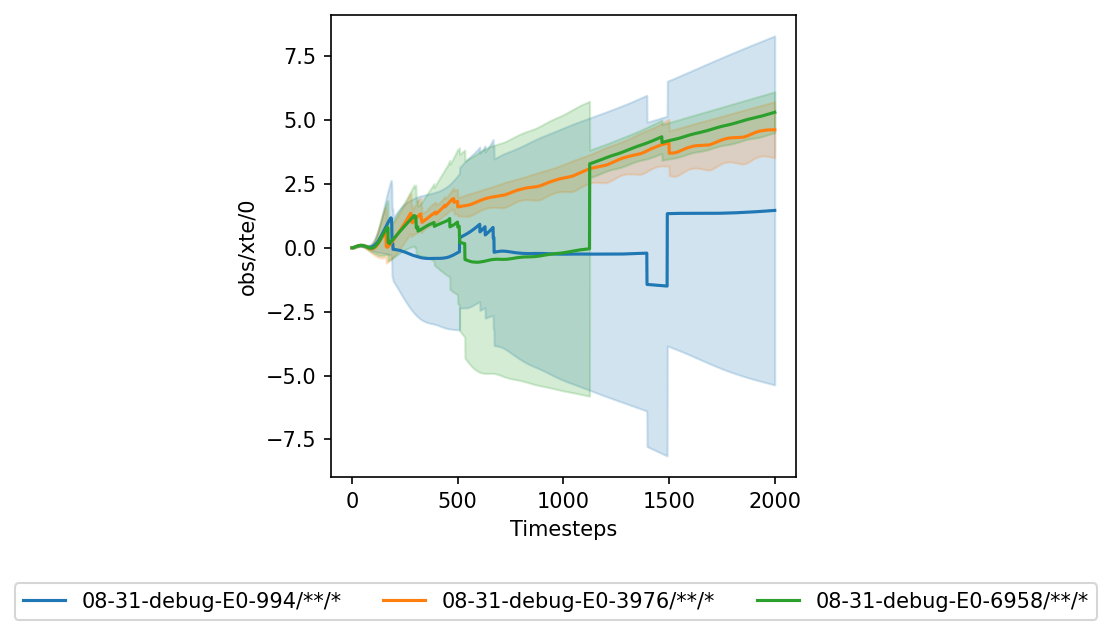

In [157]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
    '08-31-debug-E0-6958/**/*',
  ],
  metric='obs/xte/0')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


Failed to load 1 files for 08-31-debug-E0-6958/**/*


<Axes: xlabel='Timesteps', ylabel='obs/delta/0'>

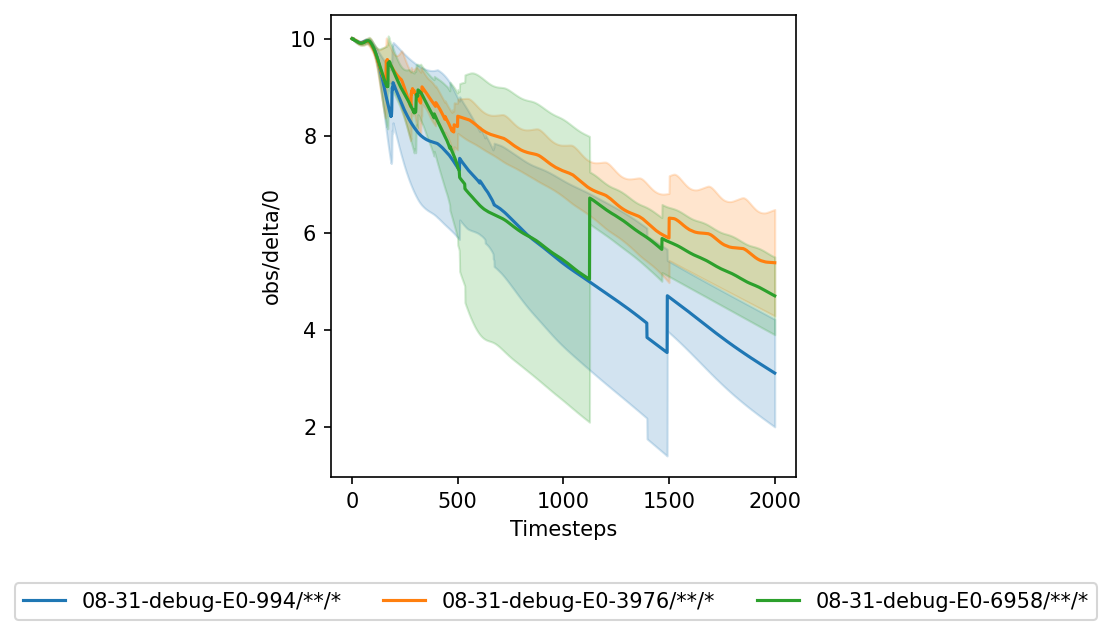

In [158]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
    '08-31-debug-E0-6958/**/*',
  ],
  metric='obs/delta/0')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


<Axes: xlabel='Timesteps', ylabel='obs/heading_error/0'>

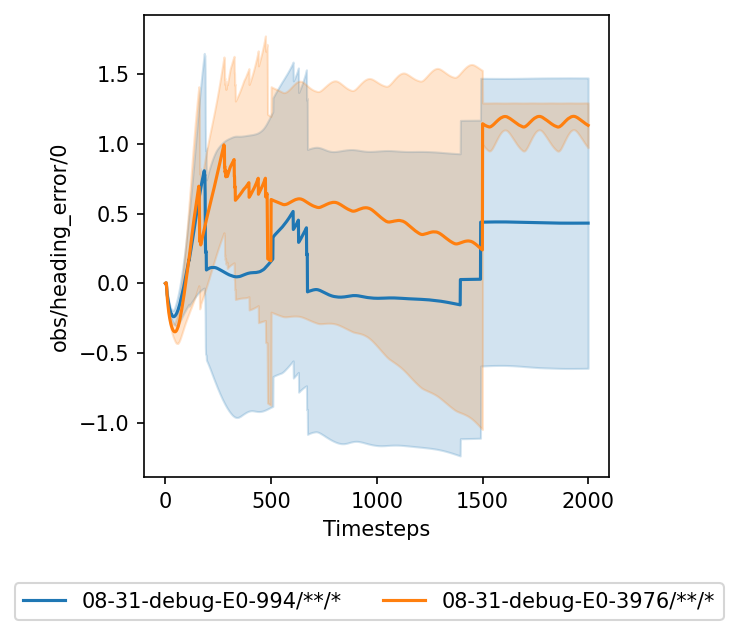

In [146]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
  ],
  metric='obs/heading_error/0')

Failed to load 1 files for 08-31-debug-E0-994/**/*


Failed to load 1 files for 08-31-debug-E0-3976/**/*


<Axes: xlabel='Timesteps', ylabel='obs/vmc/0'>

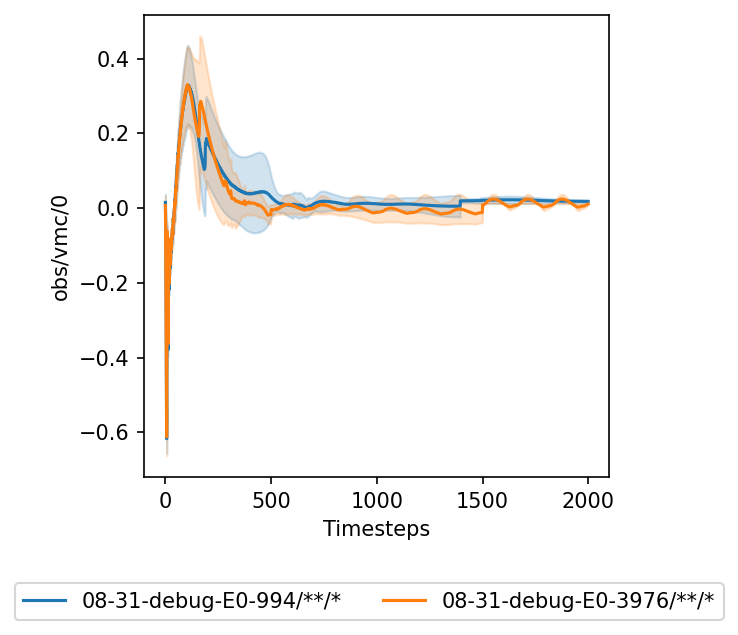

In [147]:
plot_metric(
  [
    '08-31-debug-E0-994/**/*',
    '08-31-debug-E0-3976/**/*',
  ],
  metric='obs/vmc/0')

<Axes: >

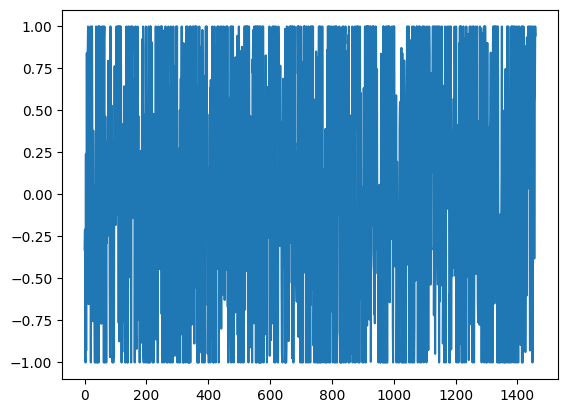

In [130]:
dfs = get_dfs('08-31-debug-E0/train-08-31-debug-E0-0/0')
df = dfs.popitem()[1]
df['act/mlp'].plot()
df['act/mlp'].plot()

Found 1 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v8            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

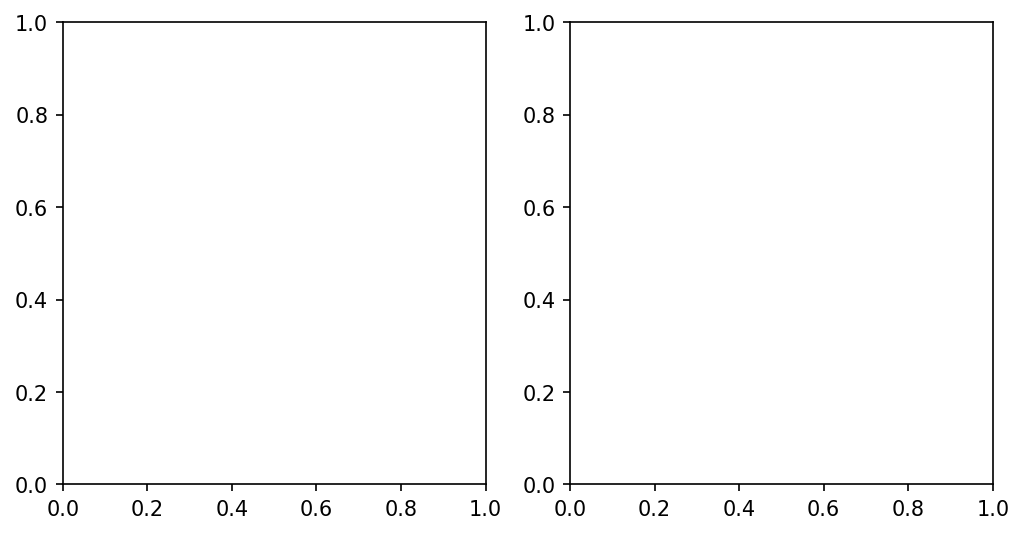

In [128]:
plot_training_evolution('08-31-debug-E0', eval=False)

# Reward

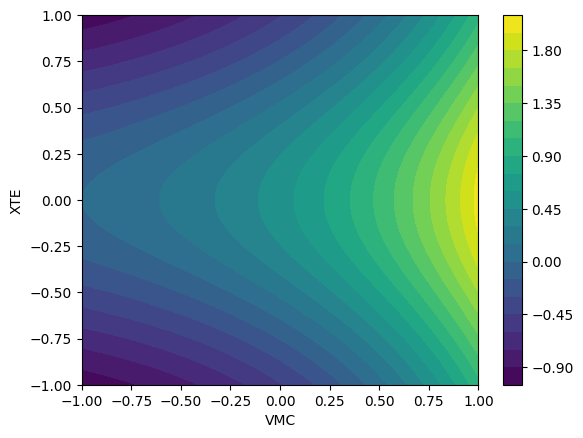

In [38]:
vmc = np.linspace(-1, 1, 100)
xte = np.linspace(-1, 1, 100)
v = 1

X, Y = np.meshgrid(vmc, xte)

r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1

R = r_vmc + r_xte
# R = -1 + (np.cos(Y) + 1)*(np.exp(-3*np.abs(X)) + 1)
# R = (np.exp(np.cos(X)) - 1) + (np.exp(-((Y)**2-1))-1)

plt.contourf(X, Y, R, levels=20)
plt.xlabel('VMC')
plt.ylabel('XTE')
plt.colorbar()

In [35]:
import numpy as np
import plotly.graph_objects as go

n = 10

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1.5))
tae = np.linspace(-np.pi, np.pi, int(n*2*np.pi))

X, Y, Z = np.meshgrid(vmc, xte, tae)
r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1
r_tae = 2*(np.exp(np.cos(Z)+1) - 1) / (np.exp(2) - 1) - 1

R = r_vmc + r_xte + r_tae

# Convert the R values into a color
colorscale = 'Viridis'
color = R.flatten()

# Plotting the data
fig = go.Figure(data=[go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode='markers',
    marker=dict(
        size=2,
        color=color,                # set color to an array/list of desired values
        colorscale=colorscale,      # choose a colorscale
        opacity=0.8,
        colorbar=dict(
            title='R Value'       # colorbar title
        )
    )
)])

# Update layout for axis labels and other settings
fig.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),
    scene=dict(
        xaxis_title='VMC',
        yaxis_title='XTE',
        zaxis_title='TAE'
    )
)

fig.show()

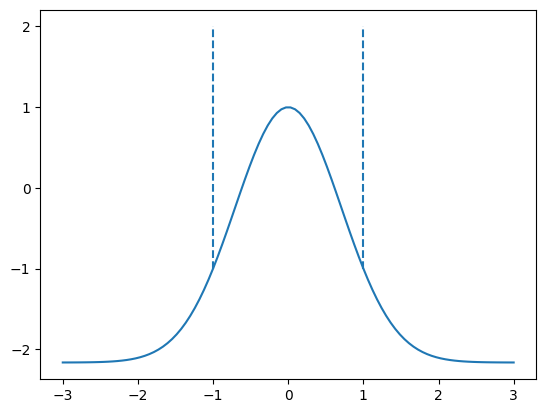

In [16]:
xte = np.linspace(-3, 3, 100)

# xte /= 10
# r = np.exp(np.cos(heading)) - 1
r = 2*(np.exp(-((xte)**2-1))-1) / (np.e - 1) - 1

plt.plot(xte, r)
# plt.vlines(-np.pi/2, -1, 2, linestyles='dashed')
# plt.vlines(np.pi/2, -1, 2, linestyles='dashed')
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

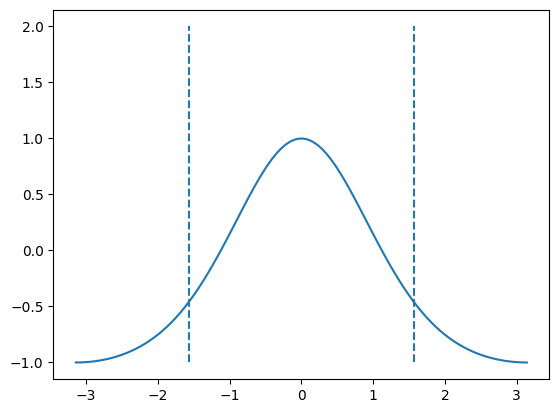

In [23]:
heading = np.linspace(-np.pi, np.pi, 100)

r = 2*(np.exp(np.cos(heading)+1) - 1) / (np.exp(2) - 1) - 1
# r = np.exp(-((xte)**2-1))-1

plt.plot(heading, r)
plt.vlines(-np.pi/2, -1, 2, linestyles='dashed')
plt.vlines(np.pi/2, -1, 2, linestyles='dashed')

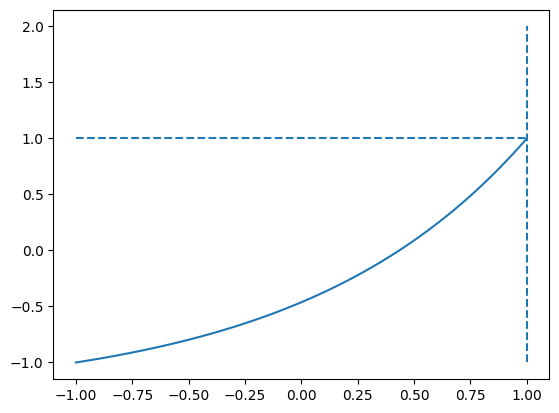

In [24]:
vmc = np.linspace(-1, 1, 100)

# r = 2*(np.exp(np.cos(heading)+1) - 1) / (np.exp(2) - 1) - 1
r = 2*(np.exp(vmc+1) - 1) / (np.exp(2) - 1) - 1
# r = np.exp(-((xte)**2-1))-1

plt.plot(vmc, r)
plt.vlines(1, -1, 2, linestyles='dashed')
plt.hlines(1, -1, 1, linestyles='dashed')